<h1>Previsão se entrevistado foi ou não internado nos ultimos 12 meses</h2>

<a>A intenção do trabalho é procurar fatores de risco que podem aumentar o risco de internação</a>

### Atributos utilizados 
J037 : Nos últimos 12 meses, ficou internado(a) em hospital por 24 horas ou mais (classe alvo)

J012: Quantas vezes consultou um médico nos últimos 12 meses

C009: Cor ou raça

C008: Idade do morador na data de referência

C006: Sexo

P050: Atualmente, o(a) Sr(a) fuma algum produto do tabaco?

P03201: Nos últimos trinta dias, o(a) Sr(a) chegou a consumir cinco ou mais doses de bebida alcoólica em uma única ocasião?

Q11604: Algum médico já lhe deu o diagnóstico de alguma outra doença crônica no pulmão, tais como enfisema pulmonar, bronquite crônica ou DPOC (Doença Pulmonar Obstrutiva Crônica)?

N001: Em geral, como o(a) Sr(a) avalia a sua saúde

Q018013: Praticar atividade física regular

Q06306: Algum médico já lhe deu o diagnóstico de uma doença do coração, tal como infarto, angina, insuficiência cardíaca ou outra?

Q068：Algum médico já lhe deu o diagnóstico de AVC (Acidente Vascular Cerebral) ou derrame?

Q074: Algum médico já lhe deu o diagnóstico de asma (ou bronquite asmática)?

Q079: Algum médico já lhe deu o diagnóstico de artrite ou reumatismo?

Q092: Algum médico ou profissional de saúde mental (como psiquiatra ou psicólogo) já lhe deu o diagnóstico de depressão?

Q11006: Algum médico ou profissional de saúde (como psiquiatra ou psicólogo) já lhe deu o diagnóstico de outra doença mental, como transtorno de ansiedade, síndrome do pânico, esquizofrenia, transtorno bipolar, psicose ou TOC (Transtorno Obsessivo Compulsivo) etc?

Q120：Algum médico já lhe deu diagnóstico de câncer?

J046: Nos últimos 12 meses, teve atendimento de urgência ou emergência no domicílio

P02602: Em quantos dias da semana o(a) Sr(a) costuma substituir a refeição do almoço por lanches rápidos como sanduíches, salgados, pizza, cachorro quente, etc?

P02601: Considerando a comida preparada na hora e os alimentos industrializados, o(a) Sr(a) acha que o seu consumo de sal é

K04301: Faz uso de algum medicamento, que foi receitado por um médico, para uso regular ou contínuo

P02501: Em quantos dias da semana o(a) Sr(a) costuma comer alimentos doces como biscoito/bolacha recheado, chocolate, gelatina, balas e outros?

Q00201: Algum médico já lhe deu o diagnóstico de hipertensão arterial (pressão alta)?

P027: Com que frequência o(a) Sr(a) costuma consumir alguma bebida alcoólica?

I00403: O plano de saúde (único ou principal) de assistência médica que possui dá direito a internações

J01101: Quando consultou um médico pela última vez

<h3>Importações</h3>

In [1]:
# Standard libraries
import logging
import warnings
import joblib

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    LabelBinarizer,
    LabelEncoder,
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Modeling and evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    recall_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay, 
)

# Machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC  # Added for Support Vector Machine
from xgboost import XGBClassifier  # Added for XGBoost
from lightgbm import LGBMClassifier  # Added for LightGBM

# Dimensionality reduction
from sklearn.decomposition import PCA

# Data balancing techniques
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Feature importance
from sklearn.inspection import permutation_importance

<h3>Carregando base

In [2]:
# Carregar os dados
df = pd.read_csv('pns2019.csv')

## Filtrando dados do problema

In [3]:
# Dados filtrados para o problema
dados = {
    'J037': 'Internacao_12_Meses', # Alvo
    'C009': 'Raca_Cor',
    'J007': 'Doenca_Cronica',
    'C008': 'Idade',
    'C006': 'Genero',
    'P050': 'Tabagismo',
    'P03201': 'Excessivo_Alcool',
    'J012':  'Numero_Consultas_Ultimo_Ano',
    'Q11604': 'Doenca_Pulmonar_Cronica',
    'N001': 'Como_Avalia_Saude',
    'Q018013': 'Pratica_Atividade_Fisica_Regular',
    'Q06306': 'Doenca_Cardiovascular',
    'Q068': 'AVC',
    'Q074': 'Asma',
    'Q079': 'Artrite',
    'Q092': 'Depressao',
    'Q11006': 'Outro_Transtorno_Mental',
    'Q120': 'Cancer',
    'Q00201': 'Hipertensao',
    'Q124': 'Insuficiencia_Renal',
    'J046': 'Atendimento_Urgencia_Domicilio',
    'P02602': 'Freq_Troca_Almoco_Por_Fast_Food',
    'P02601': 'Freq_Consumo_Sal',
    'K04301': 'Freq_Uso_medicamentos',
    'P02501': 'Freq_Consumo_Doce',
    'P027': 'Freq_bebida_alcoolica',
    'I00403': 'Plano_Saude_Cobre_Internacao',
    'J01101': 'Saude_Tempo_Ultima_Consulta_Anos'
    }

# Separação dos atributos por categoria

# Dados nominais
nominais = [
    'Raca_Cor',
    'Doenca_Cronica',
    'Genero',
    'Tabagismo',
    'Excessivo_Alcool',
    'Doenca_Pulmonar_Cronica',
    'Como_Avalia_Saude',
    'Pratica_Atividade_Fisica_Regular',
    'Doenca_Cardiovascular',
    'AVC',
    'Asma',
    'Artrite',
    'Depressao',
    'Outro_Transtorno_Mental',
    'Cancer',
    'Insuficiencia_Renal',
    'Atendimento_Urgencia_Domicilio',
    'Hipertensao',
    'Plano_Saude_Cobre_Internacao'
]

# Dados ordinais
ordinais = [
    'Freq_Troca_Almoco_Por_Fast_Food',
    'Freq_Consumo_Sal',
    'Freq_Uso_medicamentos',
    'Freq_Consumo_Doce',
    'Freq_bebida_alcoolica'
    ]

# Dados numericos
numericos = [
    'Numero_Consultas_Ultimo_Ano',
    'Saude_Tempo_Ultima_Consulta_Anos',
    'Idade'
    ]

# Filtrar as colunas usando as chaves do dicionário de renomeação
df_filtered = df.filter(dados.keys())

# Renomear as colunas com base no dicionário
df_filtered = df_filtered.rename(columns=dados)

# Eliminar colunas com target nulo
df_filtered = df_filtered.dropna(subset=['Internacao_12_Meses'])

# Exibir as primeiras linhas do dataframe para verificar
print(df_filtered.head())

   Internacao_12_Meses  Raca_Cor  Doenca_Cronica  Idade  Genero  Tabagismo  \
0                  2.0       1.0             1.0   55.0     2.0        3.0   
1                  2.0       4.0             1.0   69.0     1.0        NaN   
2                  2.0       2.0             2.0   31.0     1.0        NaN   
3                  2.0       2.0             2.0    9.0     1.0        NaN   
4                  2.0       4.0             2.0    6.0     2.0        NaN   

   Excessivo_Alcool  Numero_Consultas_Ultimo_Ano  Doenca_Pulmonar_Cronica  \
0               2.0                          2.0                      2.0   
1               NaN                          2.0                      NaN   
2               NaN                          1.0                      NaN   
3               NaN                          1.0                      NaN   
4               NaN                          1.0                      NaN   

   Como_Avalia_Saude  ...  Hipertensao  Insuficiencia_Renal  \
0    

## Checar nulos

In [4]:
# Verificar a quantidade de valores nulos em cada coluna
null_counts = df_filtered.isnull().sum()

# Exibir o resultado
print(null_counts)

Internacao_12_Meses                      0
Raca_Cor                                 0
Doenca_Cronica                           0
Idade                                    0
Genero                                   0
Tabagismo                           188536
Excessivo_Alcool                    243966
Numero_Consultas_Ultimo_Ano          72998
Doenca_Pulmonar_Cronica             188536
Como_Avalia_Saude                   188536
Pratica_Atividade_Fisica_Regular    260254
Doenca_Cardiovascular               188536
AVC                                 188536
Asma                                188536
Artrite                             188536
Depressao                           188536
Outro_Transtorno_Mental             188536
Cancer                              188536
Hipertensao                         190646
Insuficiencia_Renal                 188536
Atendimento_Urgencia_Domicilio           0
Freq_Troca_Almoco_Por_Fast_Food     188536
Freq_Consumo_Sal                    188536
Freq_Uso_me

## O filtro para os NaN vai ser 70%. Os que passarem serão imputados.

In [5]:
# Calcular a proporção de valores nulos em cada coluna
percentual_nulos = df_filtered.isnull().mean()

# Filtrar as colunas que têm menos de 70% de valores nulos
colunas_validas = percentual_nulos[percentual_nulos < 0.70].index

# Manter apenas as colunas que têm menos de 70% de valores nulos
df_filtered = df_filtered[colunas_validas]

# Exibir as primeiras linhas do dataframe para verificar
print(df_filtered.head())

# Atualizar as listas de categorias removendo elementos com mais de 70% de nulos
nominais = [col for col in nominais if col in colunas_validas]
ordinais = [col for col in ordinais if col in colunas_validas]
numericos = [col for col in numericos if col in colunas_validas]

   Internacao_12_Meses  Raca_Cor  Doenca_Cronica  Idade  Genero  Tabagismo  \
0                  2.0       1.0             1.0   55.0     2.0        3.0   
1                  2.0       4.0             1.0   69.0     1.0        NaN   
2                  2.0       2.0             2.0   31.0     1.0        NaN   
3                  2.0       2.0             2.0    9.0     1.0        NaN   
4                  2.0       4.0             2.0    6.0     2.0        NaN   

   Numero_Consultas_Ultimo_Ano  Doenca_Pulmonar_Cronica  Como_Avalia_Saude  \
0                          2.0                      2.0                3.0   
1                          2.0                      NaN                NaN   
2                          1.0                      NaN                NaN   
3                          1.0                      NaN                NaN   
4                          1.0                      NaN                NaN   

   Doenca_Cardiovascular  ...  Outro_Transtorno_Mental  Cancer

## Imputando

In [6]:
# Imputando valores numericos/nominais faltantes
imputer_median = SimpleImputer(strategy='median')
df_filtered[ordinais] = imputer_median.fit_transform(df_filtered[ordinais])
df_filtered[numericos] = imputer_median.fit_transform(df_filtered[numericos])

# Imputando valores nominais faltantes
imputer_mode = SimpleImputer(strategy='most_frequent')
df_filtered[nominais] = imputer_mode.fit_transform(df_filtered[nominais])

In [7]:
# Verificar a quantidade de valores nulos em cada coluna
null_counts = df_filtered.isnull().sum()

# Exibir o resultado
print(null_counts)

# Binarizar o alvos
imputer_median = SimpleImputer(strategy='median')

# Fit the imputer on numeric columns and transform the data
df_filtered[nominais] = imputer_median.fit_transform(df_filtered[nominais])

print("\nDataFrame after imputing numeric columns:")
print(df_filtered)

Internacao_12_Meses                 0
Raca_Cor                            0
Doenca_Cronica                      0
Idade                               0
Genero                              0
Tabagismo                           0
Numero_Consultas_Ultimo_Ano         0
Doenca_Pulmonar_Cronica             0
Como_Avalia_Saude                   0
Doenca_Cardiovascular               0
AVC                                 0
Asma                                0
Artrite                             0
Depressao                           0
Outro_Transtorno_Mental             0
Cancer                              0
Hipertensao                         0
Insuficiencia_Renal                 0
Atendimento_Urgencia_Domicilio      0
Freq_Troca_Almoco_Por_Fast_Food     0
Freq_Consumo_Sal                    0
Freq_Consumo_Doce                   0
Freq_bebida_alcoolica               0
Saude_Tempo_Ultima_Consulta_Anos    0
dtype: int64

DataFrame after imputing numeric columns:
        Internacao_12_Meses  Rac

## Box Plot dos atributos para detecção de outliers

### Muitos problemas de saúde afetam uma pequena parte da população, então é esperado outliers

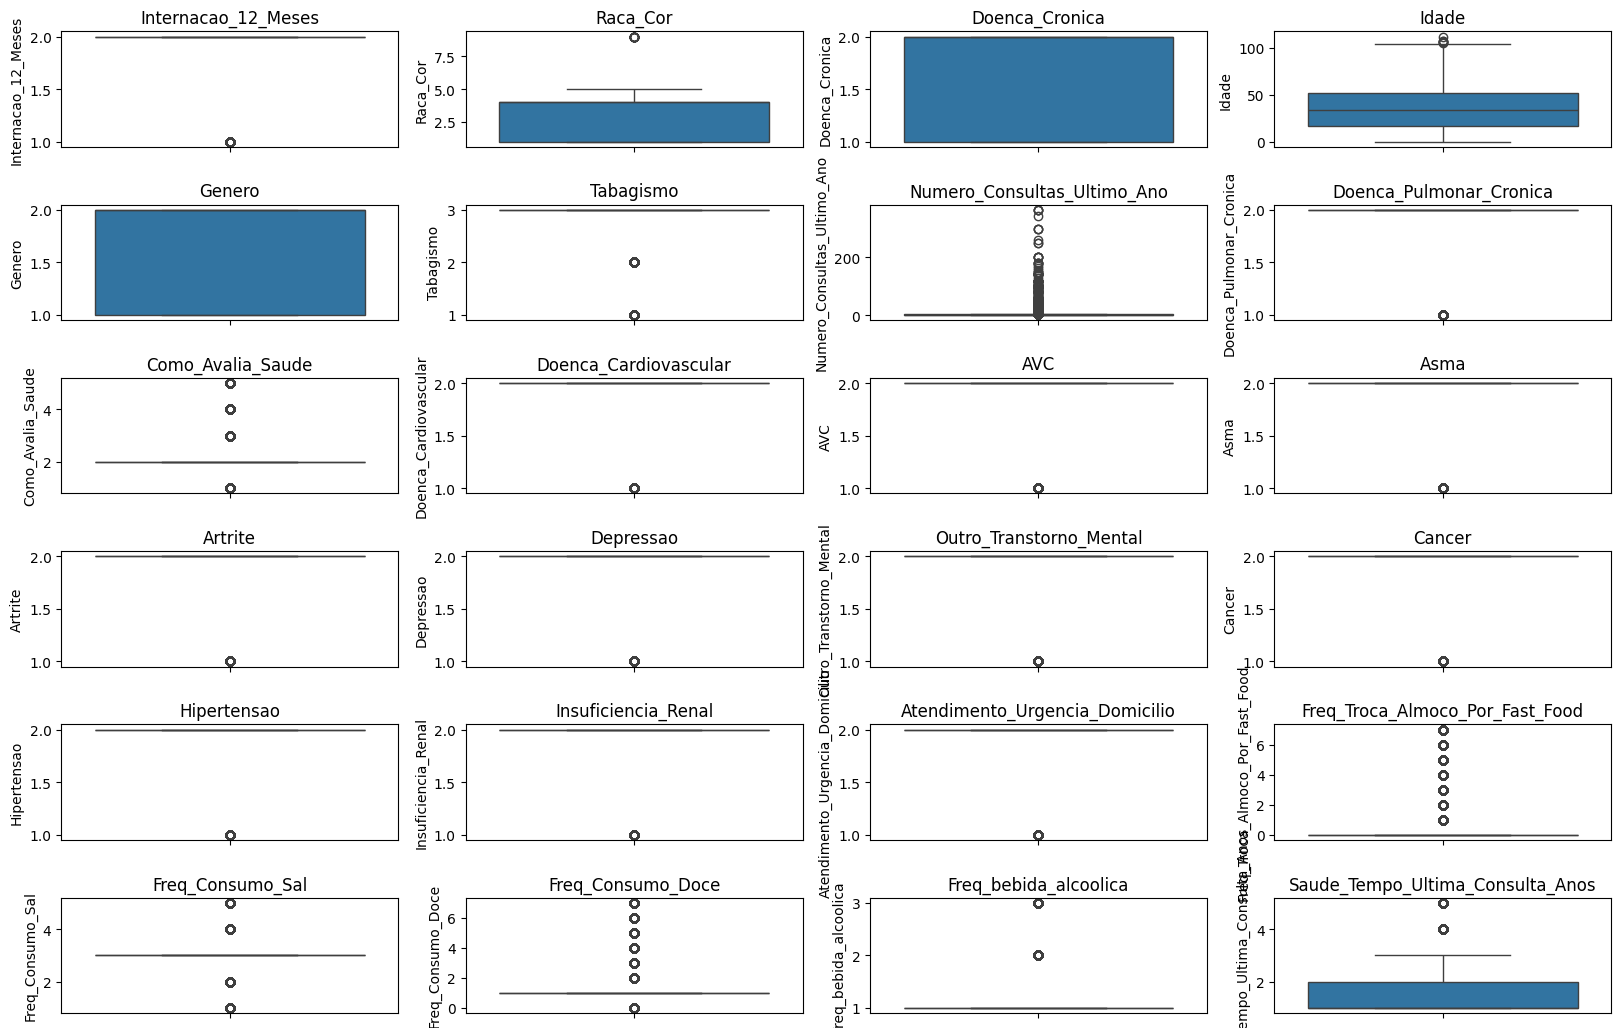

In [8]:
# Definir o número de linhas e colunas para o grid de boxplots
num_cols = 4  # Número de colunas no grid
num_rows = (len(df_filtered.columns) // num_cols) + 1  # Calcular o número de linhas com base no número de colunas

# Criar o grid de subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

# Ajustar o espaçamento entre os subplots
plt.subplots_adjust(hspace=0.5)

# Loop sobre as colunas e plotar cada boxplot em um subplot
for i, column in enumerate(df_filtered.columns):
    row = i // num_cols  # Determinar a linha no grid
    col = i % num_cols   # Determinar a coluna no grid
    sns.boxplot(data=df_filtered[column], ax=axes[row, col])
    axes[row, col].set_title(column)

# Remover subplots vazios, caso o número de colunas não seja divisível
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes.flatten()[j])

# Exibir o gráfico
plt.show()

## Visualizando graficos

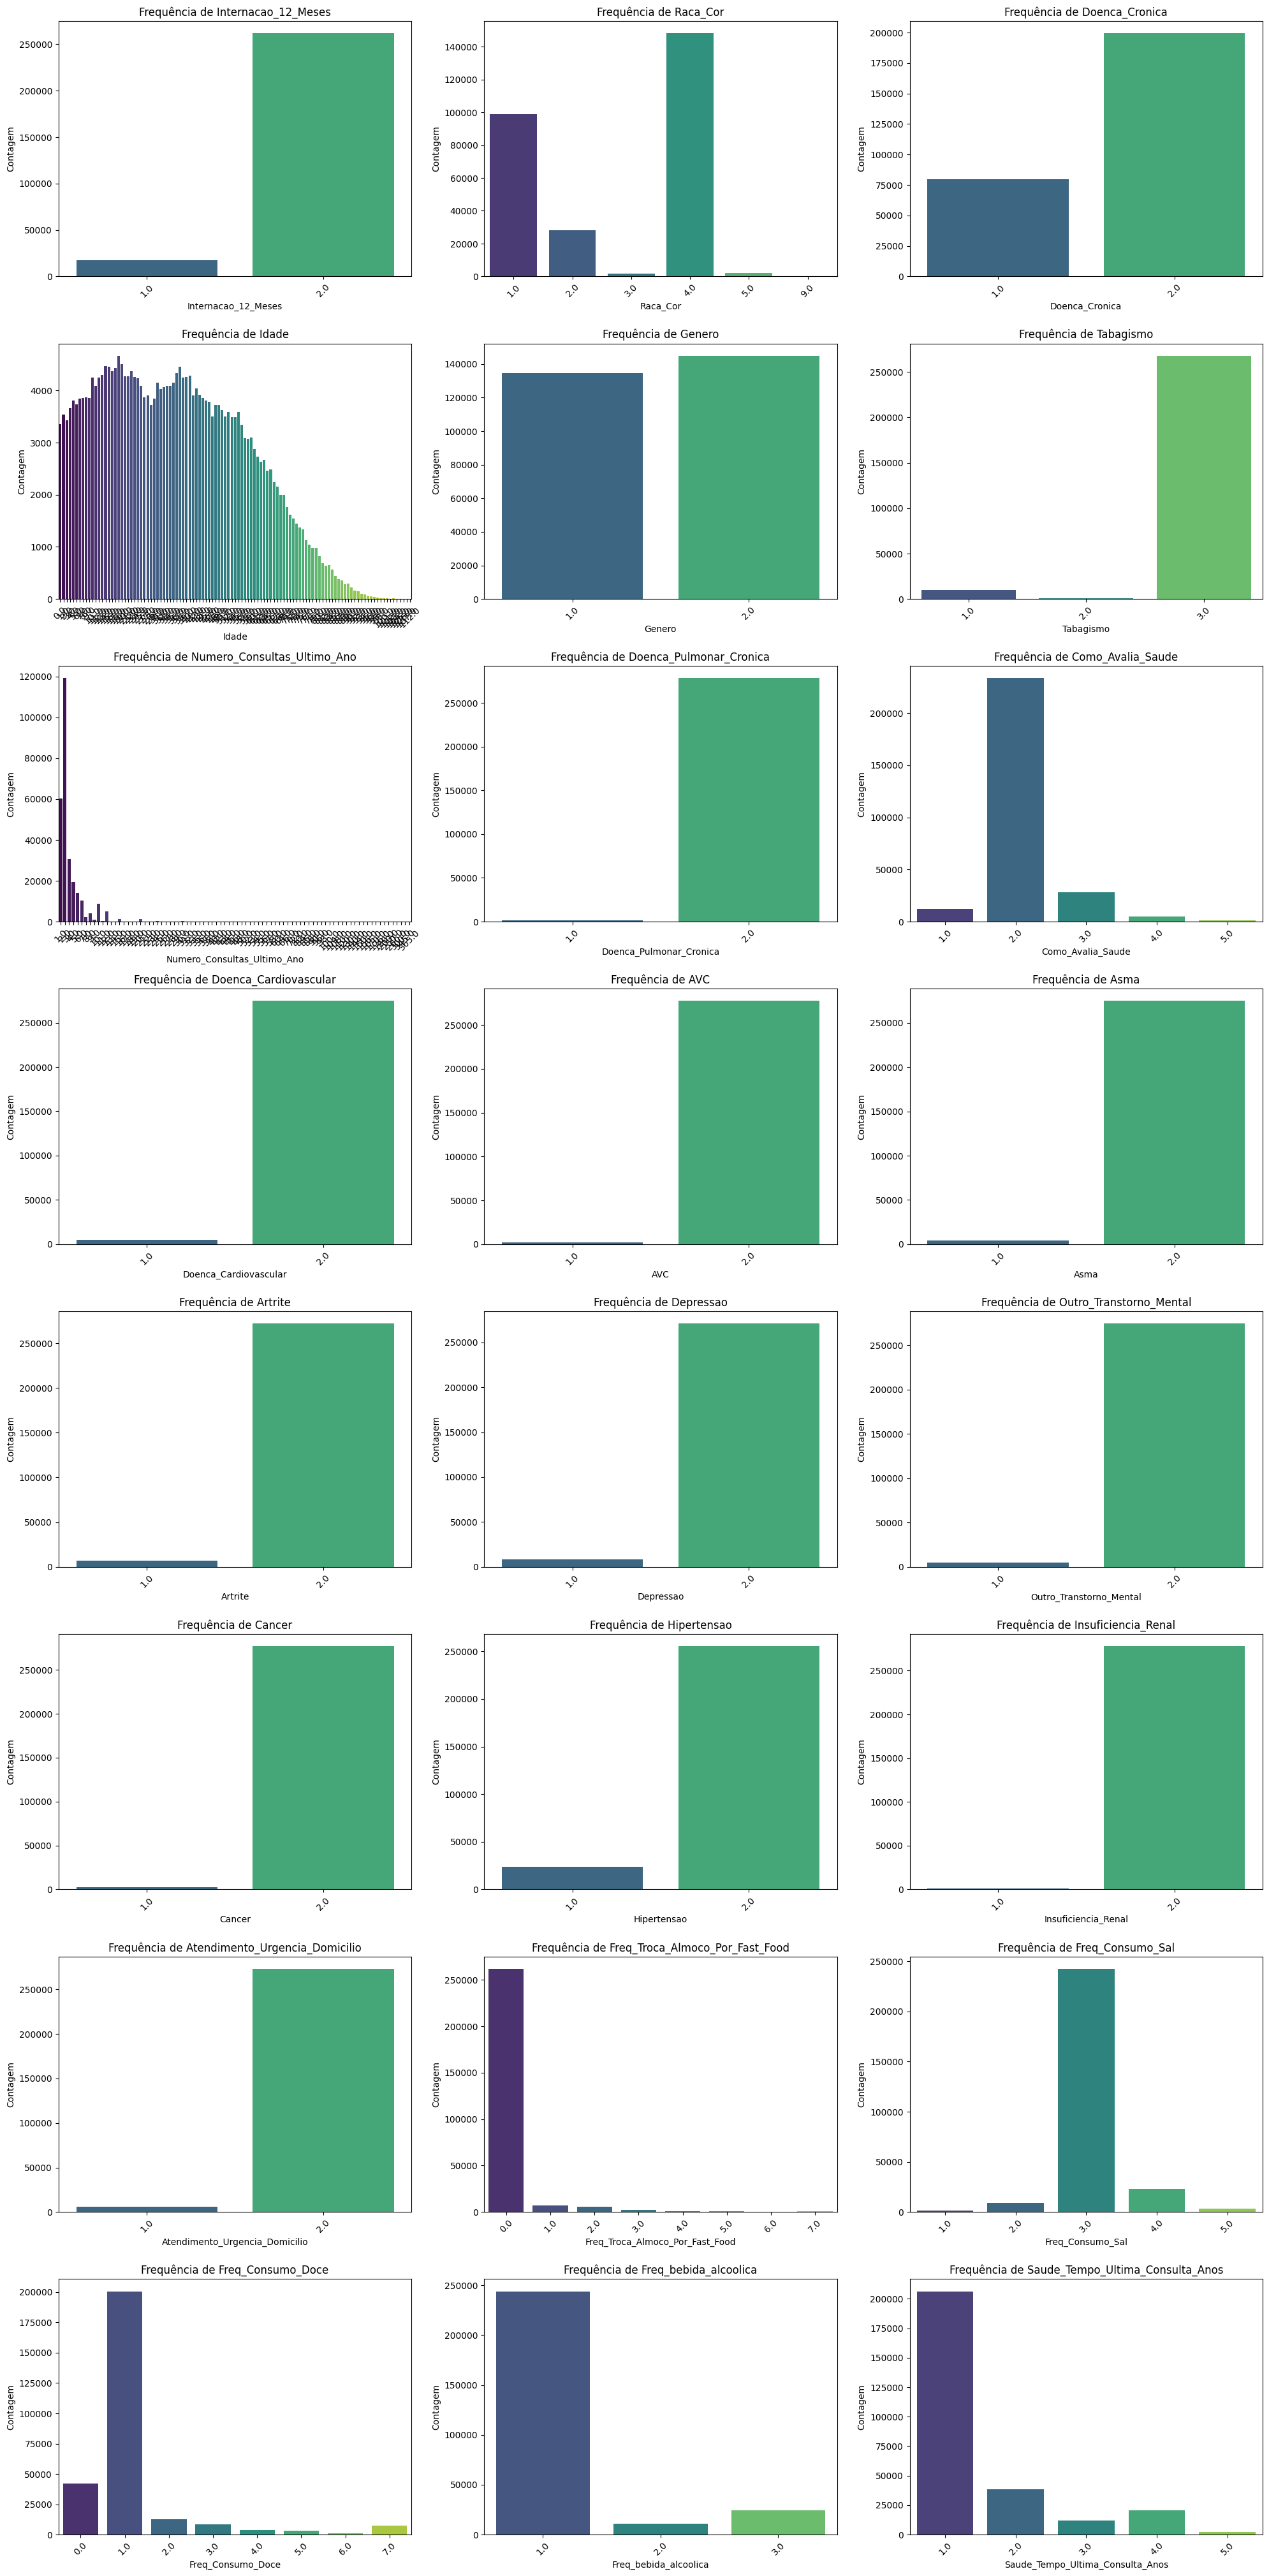

In [9]:
import warnings

# Suprimir apenas FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Definir número de colunas e calcular número de linhas para os subplots
num_cols = 3
num_rows = (len(df_filtered.columns) // num_cols) + 1

# Criar subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 5))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Flatten os eixos para facilitar a iteração
axes = axes.flatten()

# Loop sobre as colunas e plotar cada gráfico de barras em um subplot
for i, column in enumerate(df_filtered.columns):
    ax = axes[i]
    # Contar a frequência de cada valor na coluna
    counts = df_filtered[column].value_counts().sort_index()
    sns.barplot(x=counts.index, y=counts.values, ax=ax, palette='viridis')
    ax.set_title(f"Frequência de {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Contagem")
    ax.tick_params(axis='x', rotation=45)

# Remover subplots vazios, caso o número de colunas não seja divisível por num_cols
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()

## Separando dados

In [10]:
# Separando df X e y
X = df_filtered.drop(columns=['Internacao_12_Meses'])
y = df_filtered['Internacao_12_Meses']

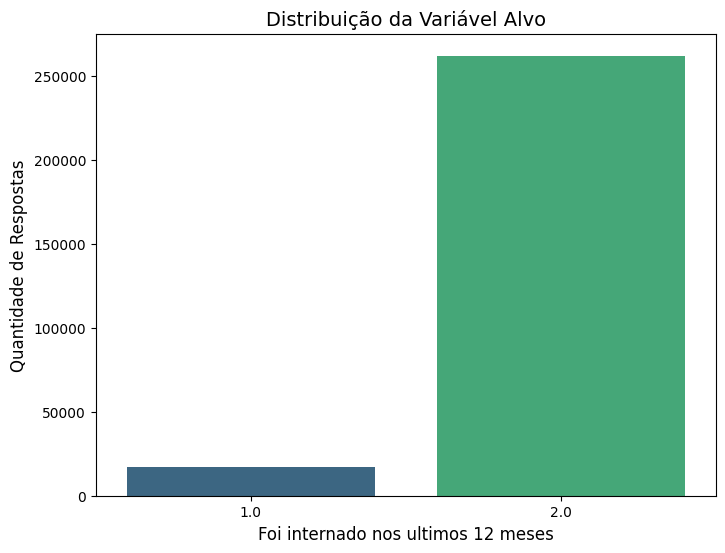

In [11]:
# Criar o gráfico de barras usando seaborn
plt.figure(figsize=(8,6))
sns.countplot(x=y, palette='viridis')

# Adicionar título e rótulos aos eixos
plt.title('Distribuição da Variável Alvo', fontsize=14)
plt.xlabel('Foi internado nos ultimos 12 meses', fontsize=12)
plt.ylabel('Quantidade de Respostas', fontsize=12)

# Exibir o gráfico
plt.show()

## Train test split

In [12]:
# Dividindo o conjunto balanceado em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Balanceando com undersampling

In [13]:
# Inicializar o RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Aplicar o RandomUnderSampler apenas no conjunto de treinamento
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

# Verificar a nova distribuição das classes no conjunto de treinamento balanceado
print("\nDistribuição das classes após aplicar o RandomUnderSampler no conjunto de treinamento:")
print(pd.Series(y_train_balanced).value_counts(normalize=True))



Distribuição das classes após aplicar o RandomUnderSampler no conjunto de treinamento:
Internacao_12_Meses
1.0    0.5
2.0    0.5
Name: proportion, dtype: float64


## Estrutura do pipeline para encode

In [14]:
# Definir o pipeline de pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numericos),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinais),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominais)
    ],
    remainder='drop'
)

## Visualizando correlação de atributos

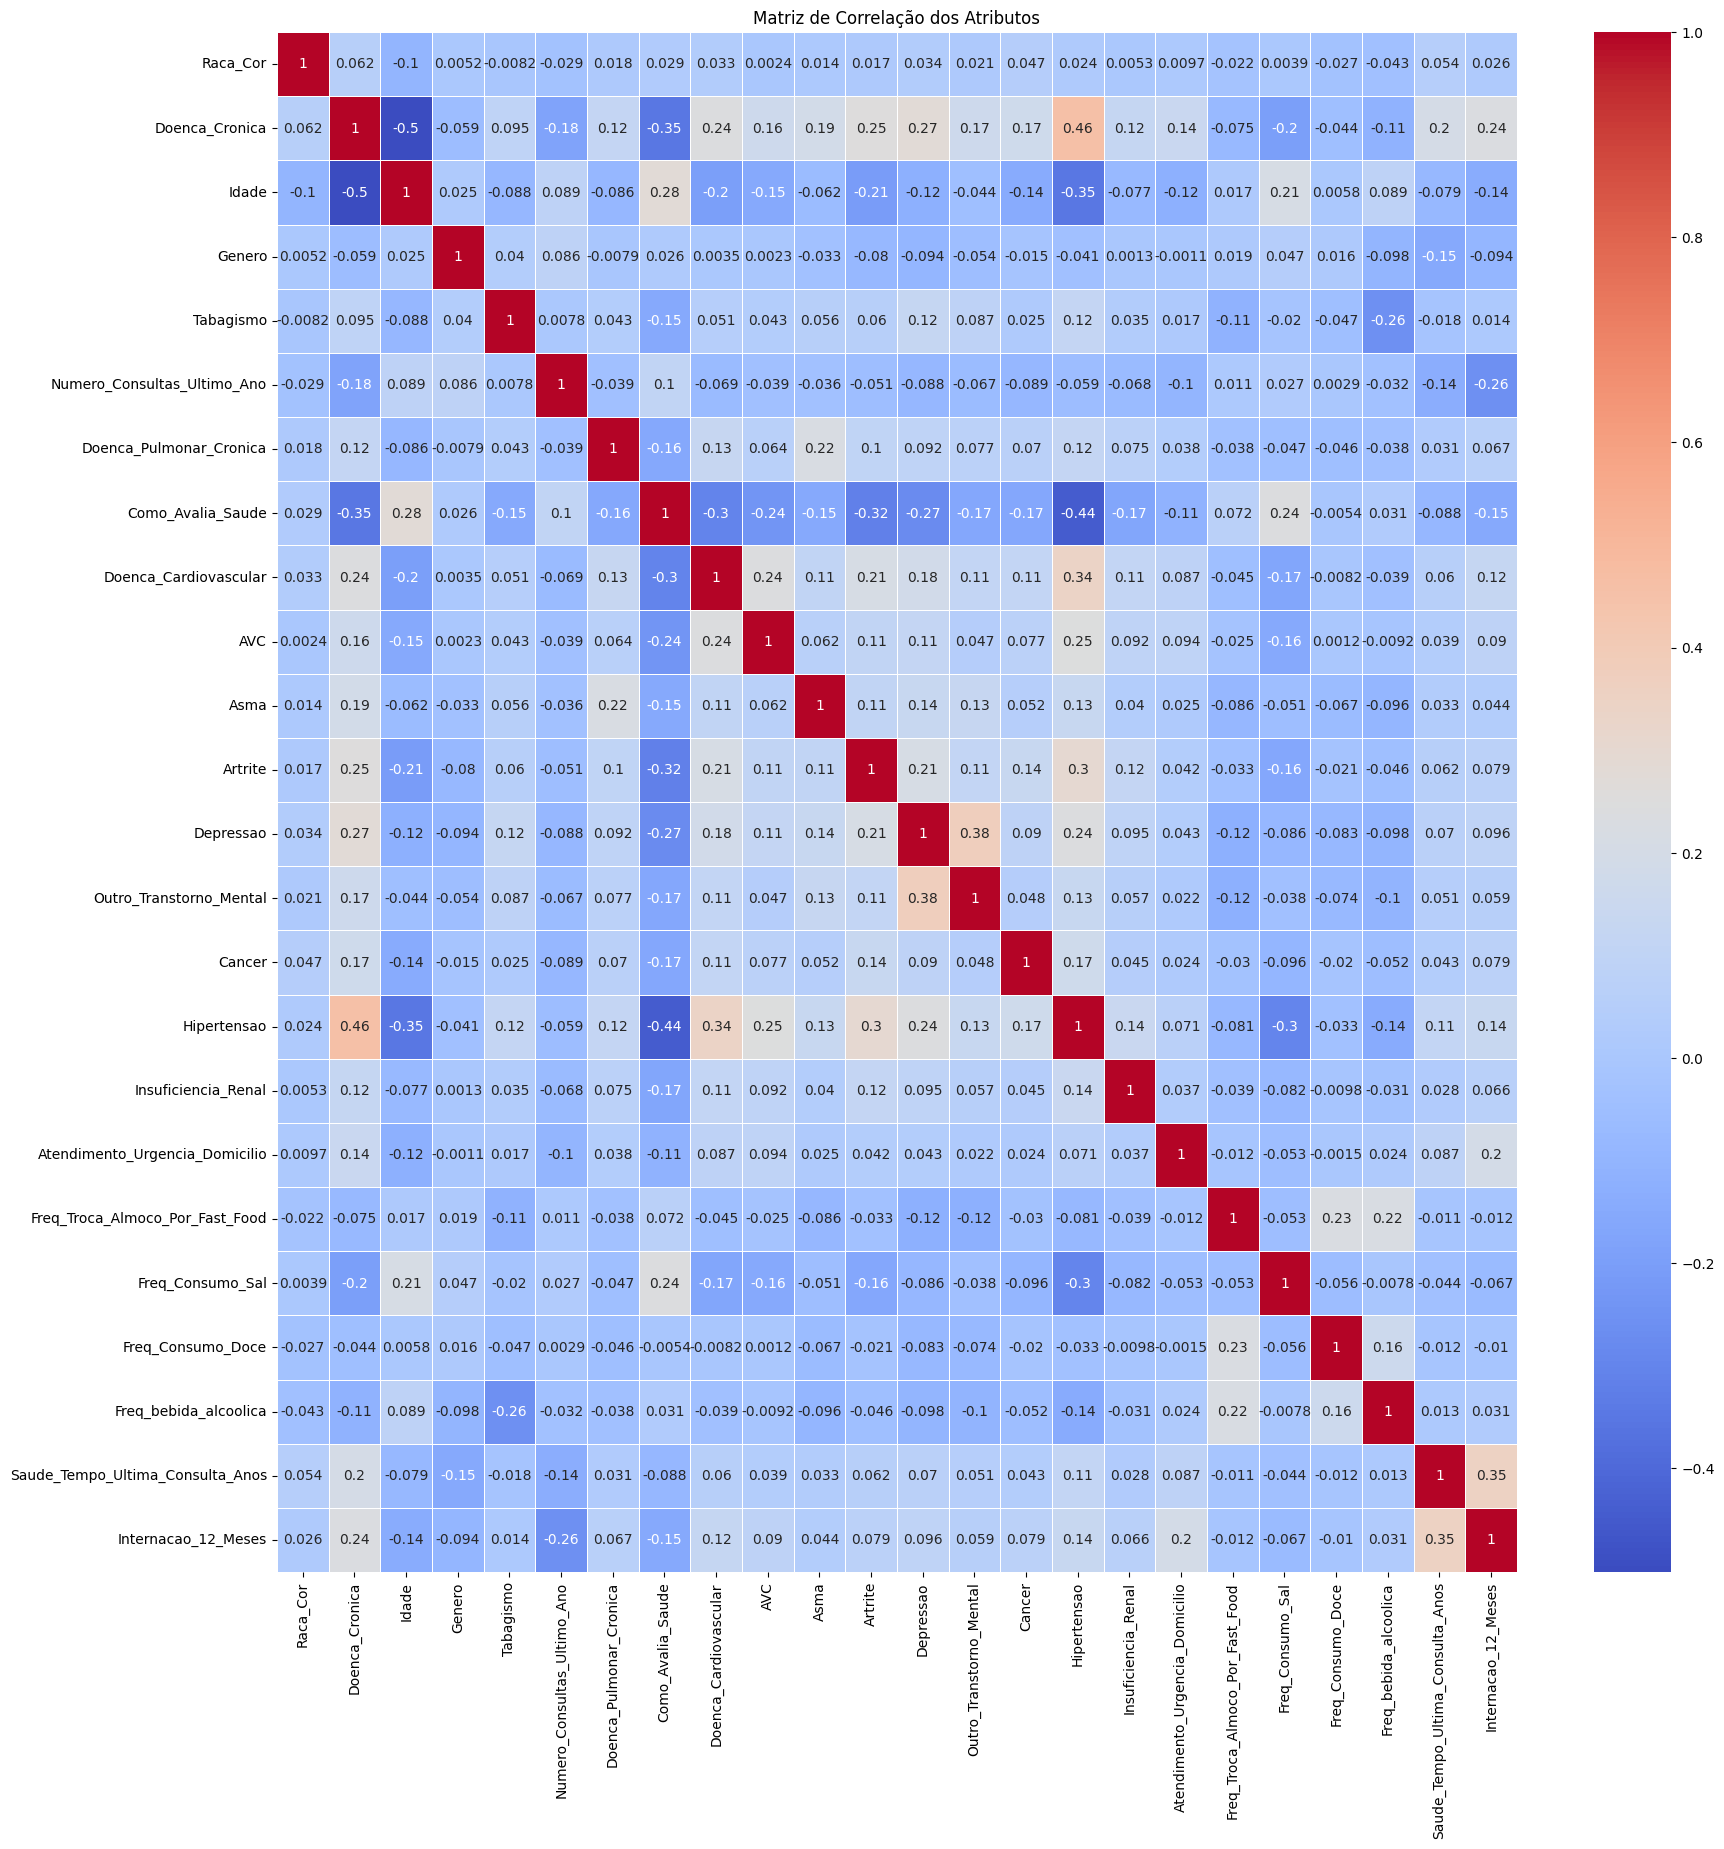

In [15]:
df_balanceado = pd.concat([X_train_balanced, y_train_balanced], axis=1)
correlacao = df_balanceado.corr()
plt.figure(figsize=(20, 20))  # Ajustar o tamanho do gráfico
sns.heatmap(correlacao, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação dos Atributos')
plt.show()

## Analisando correlações

In [16]:
# Filtrar as correlações relacionadas à variável alvo 'Internacao_12_Meses'
correlacao_alvo = correlacao['Internacao_12_Meses']

# Ordenar as correlações por valor absoluto, do mais relacionado ao menos relacionado
correlacao_alvo_ordenada = correlacao_alvo.abs().sort_values(ascending=False)

# Exibir as correlações mais fortes
print("Atributos mais relacionados com 'Internacao_12_Meses':")
print(correlacao_alvo_ordenada[1:])

Atributos mais relacionados com 'Internacao_12_Meses':
Saude_Tempo_Ultima_Consulta_Anos    0.350088
Numero_Consultas_Ultimo_Ano         0.255688
Doenca_Cronica                      0.237462
Atendimento_Urgencia_Domicilio      0.196198
Como_Avalia_Saude                   0.154252
Idade                               0.137621
Hipertensao                         0.136889
Doenca_Cardiovascular               0.121850
Depressao                           0.095747
Genero                              0.094253
AVC                                 0.089798
Artrite                             0.078797
Cancer                              0.078569
Freq_Consumo_Sal                    0.067432
Doenca_Pulmonar_Cronica             0.067012
Insuficiencia_Renal                 0.065502
Outro_Transtorno_Mental             0.059100
Asma                                0.043755
Freq_bebida_alcoolica               0.030903
Raca_Cor                            0.026488
Tabagismo                           0.013903


In [17]:
X_train_balanced

,Raca_Cor,Doenca_Cronica,Idade,Genero,Tabagismo,Numero_Consultas_Ultimo_Ano,Doenca_Pulmonar_Cronica,Como_Avalia_Saude,Doenca_Cardiovascular,AVC,...,Outro_Transtorno_Mental,Cancer,Hipertensao,Insuficiencia_Renal,Atendimento_Urgencia_Domicilio,Freq_Troca_Almoco_Por_Fast_Food,Freq_Consumo_Sal,Freq_Consumo_Doce,Freq_bebida_alcoolica,Saude_Tempo_Ultima_Consulta_Anos
68734,4.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
177357,2.0,2.0,25.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
125706,4.0,2.0,4.0,1.0,3.0,5.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
252282,1.0,1.0,74.0,2.0,3.0,4.0,2.0,3.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,3.0,0.0,1.0,1.0
229593,1.0,1.0,46.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,2.0,0.0,3.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128847,4.0,1.0,57.0,2.0,3.0,8.0,2.0,3.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,0.0,3.0,1.0,2.0,1.0
287967,1.0,1.0,31.0,2.0,3.0,10.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,6.0,2.0,1.0
8651,4.0,1.0,63.0,2.0,1.0,3.0,2.0,2.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,0.0,3.0,0.0,3.0,1.0
43516,1.0,2.0,18.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0


In [18]:
X_test

,Raca_Cor,Doenca_Cronica,Idade,Genero,Tabagismo,Numero_Consultas_Ultimo_Ano,Doenca_Pulmonar_Cronica,Como_Avalia_Saude,Doenca_Cardiovascular,AVC,...,Outro_Transtorno_Mental,Cancer,Hipertensao,Insuficiencia_Renal,Atendimento_Urgencia_Domicilio,Freq_Troca_Almoco_Por_Fast_Food,Freq_Consumo_Sal,Freq_Consumo_Doce,Freq_bebida_alcoolica,Saude_Tempo_Ultima_Consulta_Anos
276932,4.0,2.0,11.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,2.0
146559,4.0,2.0,74.0,2.0,3.0,6.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
36518,4.0,2.0,18.0,1.0,3.0,2.0,2.0,3.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,4.0,2.0,3.0,2.0
281960,4.0,2.0,2.0,2.0,3.0,6.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
30057,4.0,1.0,14.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25266,4.0,2.0,12.0,2.0,3.0,4.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
23217,4.0,2.0,6.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
209240,4.0,2.0,2.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0
101876,4.0,1.0,53.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0


In [19]:
y_train_balanced

68734     1.0
177357    1.0
125706    1.0
252282    1.0
229593    1.0
         ... 
128847    2.0
287967    2.0
8651      2.0
43516     2.0
175906    2.0
Name: Internacao_12_Meses, Length: 27828, dtype: float64

In [20]:
y_test

276932    2.0
146559    2.0
36518     2.0
281960    2.0
30057     2.0
         ... 
25266     2.0
23217     2.0
209240    2.0
101876    2.0
262547    2.0
Name: Internacao_12_Meses, Length: 55877, dtype: float64

### Treinando


Treinando o modelo: Decision Tree
Fitting 5 folds for each of 135 candidates, totalling 675 fits
Melhores hiperparâmetros para Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}


<Figure size 800x600 with 0 Axes>

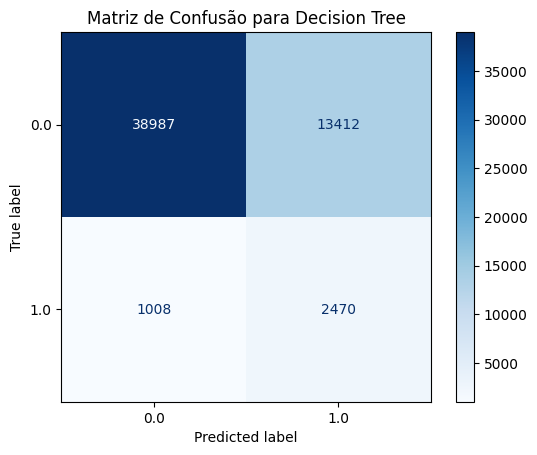

Relatório de Classificação para Decision Tree:

              precision    recall  f1-score   support

         0.0       0.97      0.74      0.84     52399
         1.0       0.16      0.71      0.26      3478

    accuracy                           0.74     55877
   macro avg       0.57      0.73      0.55     55877
weighted avg       0.92      0.74      0.81     55877

Acurácia: 0.7419
ROC-AUC: 0.8087


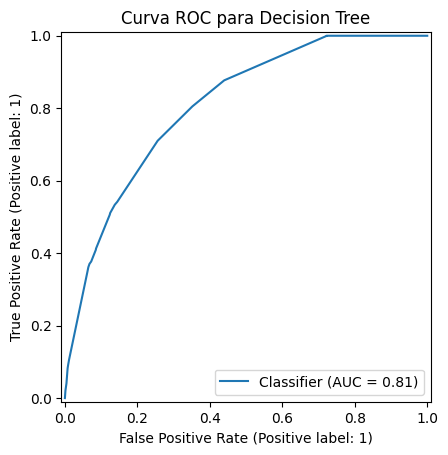

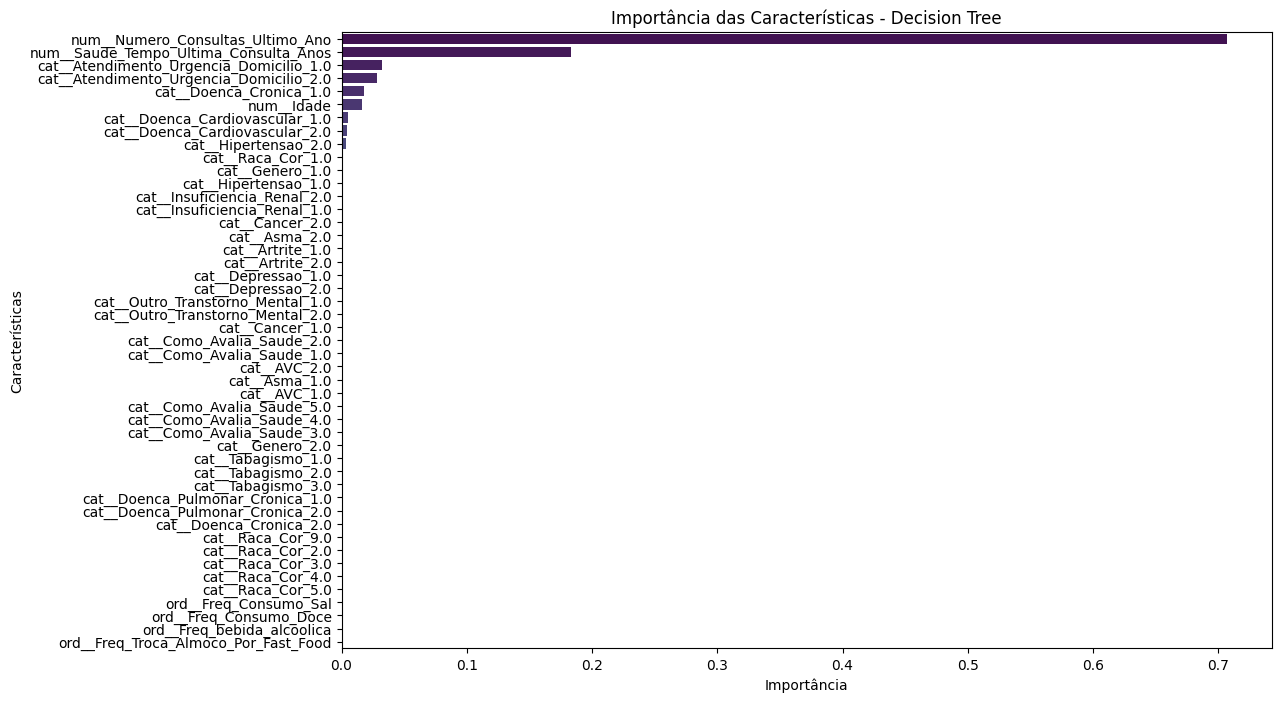


Treinando o modelo: Random Forest
Fitting 5 folds for each of 648 candidates, totalling 3240 fits


c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
472 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\pipeline.py", line 473,

Melhores hiperparâmetros para Random Forest: {'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


<Figure size 800x600 with 0 Axes>

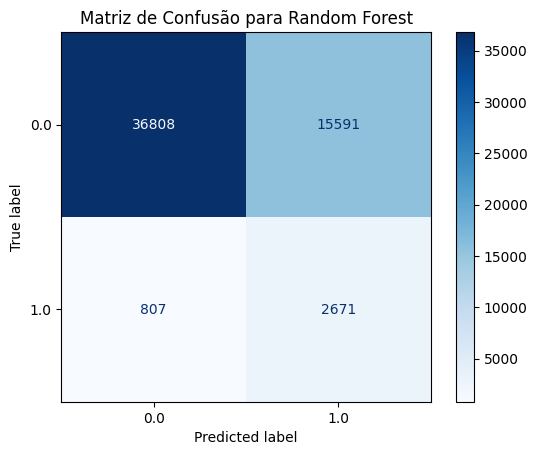

Relatório de Classificação para Random Forest:

              precision    recall  f1-score   support

         0.0       0.98      0.70      0.82     52399
         1.0       0.15      0.77      0.25      3478

    accuracy                           0.71     55877
   macro avg       0.56      0.74      0.53     55877
weighted avg       0.93      0.71      0.78     55877

Acurácia: 0.7065
ROC-AUC: 0.8205


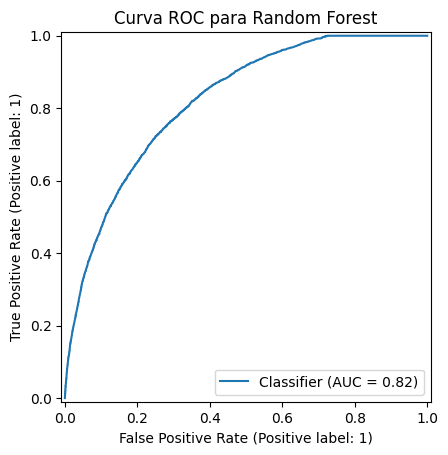

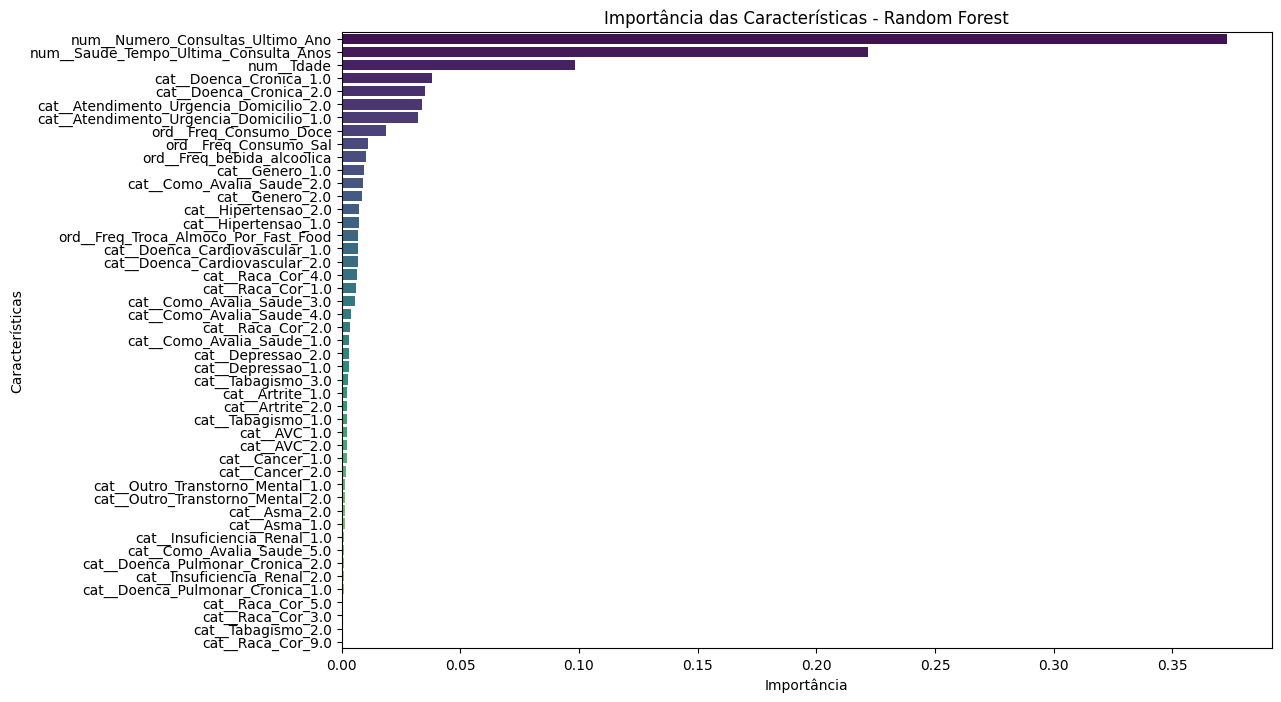


Treinando o modelo: MLP Neural Network
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Melhores hiperparâmetros para MLP Neural Network: {'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}


<Figure size 800x600 with 0 Axes>

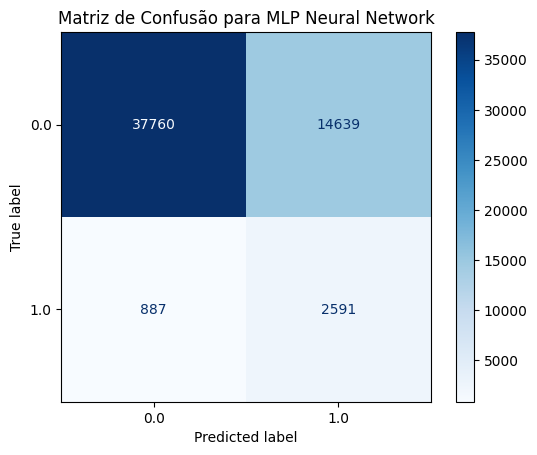

Relatório de Classificação para MLP Neural Network:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     52399
         1.0       0.15      0.74      0.25      3478

    accuracy                           0.72     55877
   macro avg       0.56      0.73      0.54     55877
weighted avg       0.93      0.72      0.79     55877

Acurácia: 0.7221
ROC-AUC: 0.8169


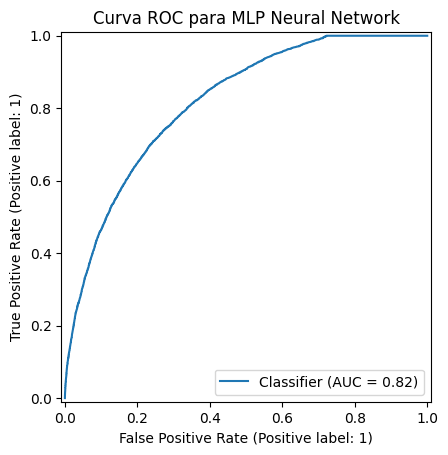

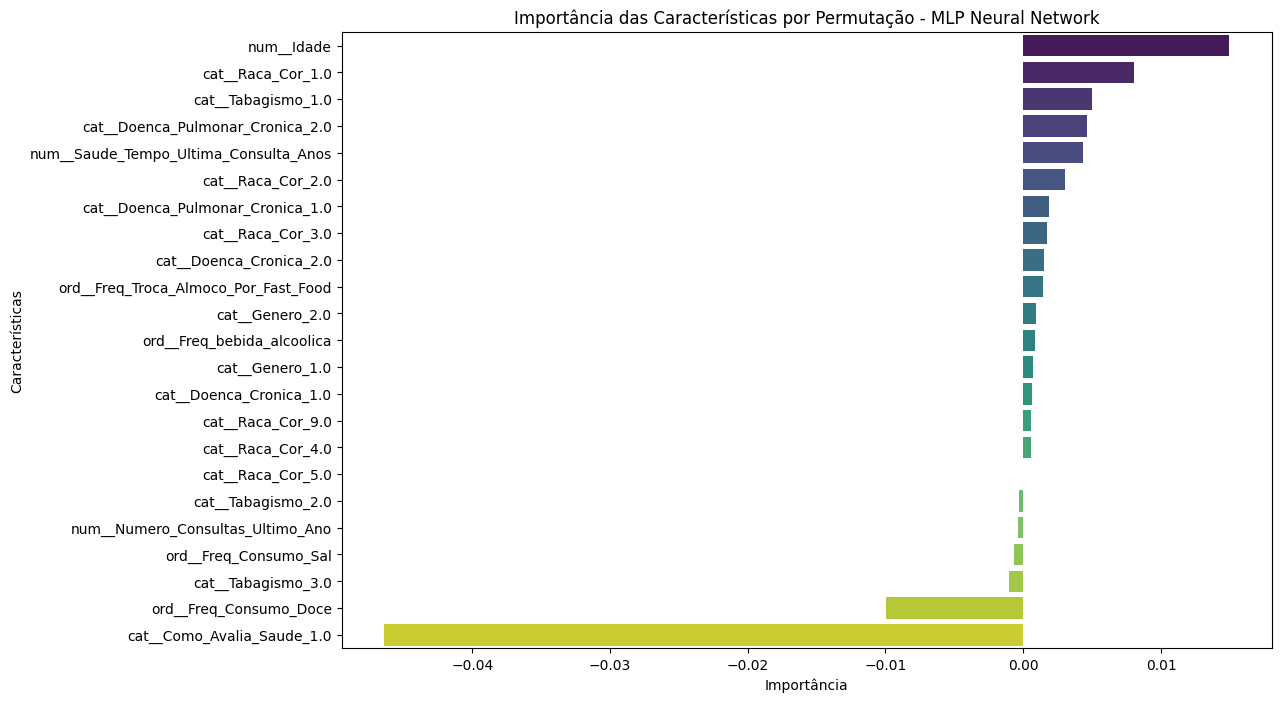


Treinando o modelo: Gradient Boosting
Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
140 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\sklearn\pipeline.py", line 473, i

Melhores hiperparâmetros para Gradient Boosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__max_features': 'log2', 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}


<Figure size 800x600 with 0 Axes>

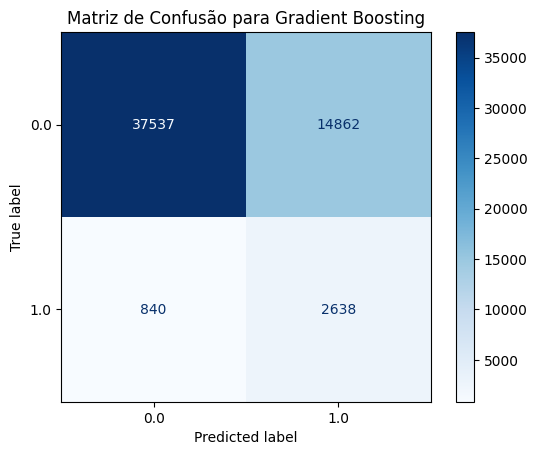

Relatório de Classificação para Gradient Boosting:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     52399
         1.0       0.15      0.76      0.25      3478

    accuracy                           0.72     55877
   macro avg       0.56      0.74      0.54     55877
weighted avg       0.93      0.72      0.79     55877

Acurácia: 0.7190
ROC-AUC: 0.8204


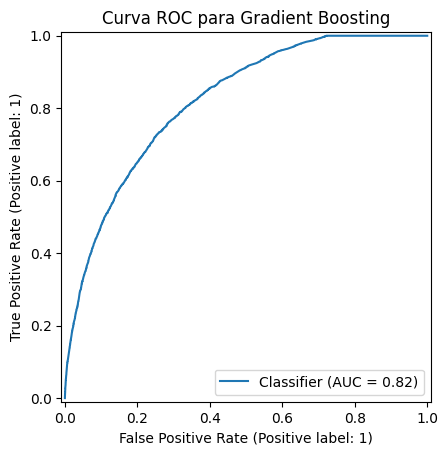

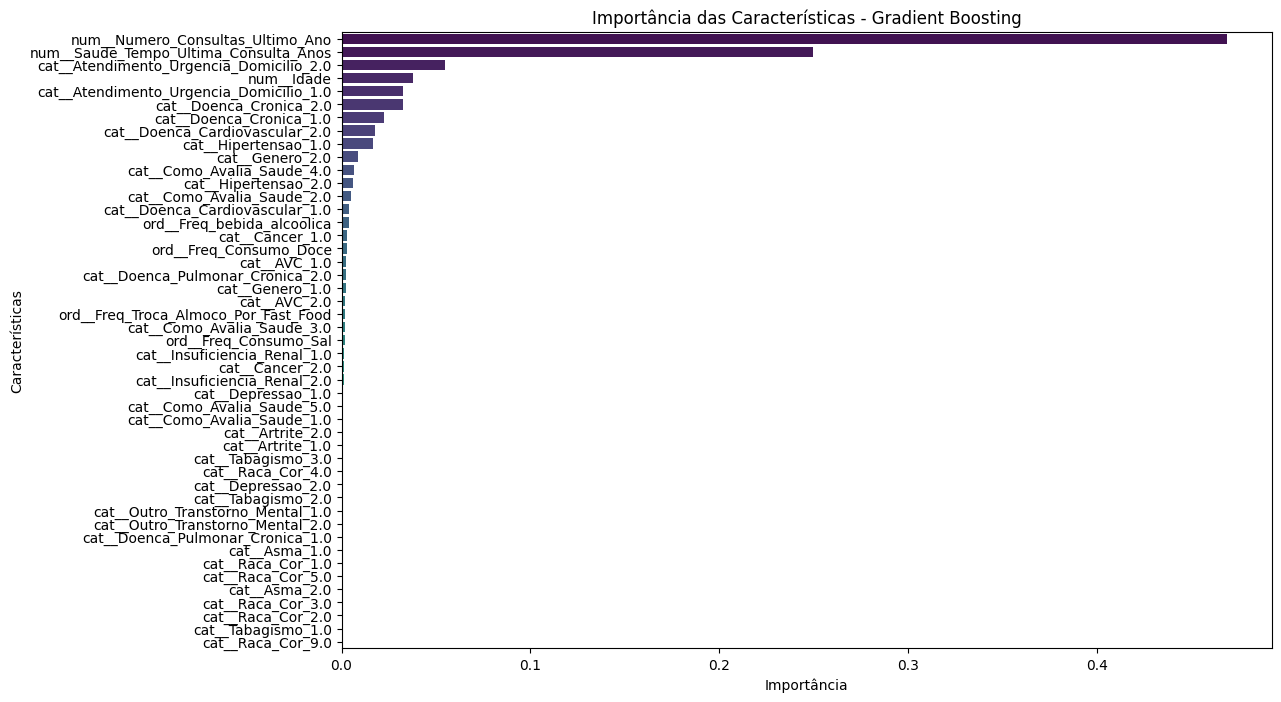


Treinando o modelo: Support Vector Machine
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Melhores hiperparâmetros para Support Vector Machine: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


<Figure size 800x600 with 0 Axes>

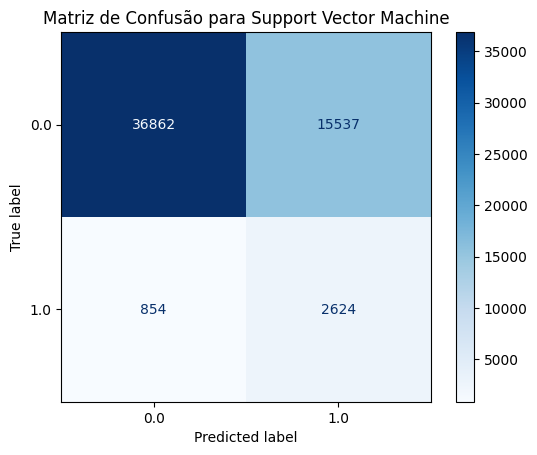

Relatório de Classificação para Support Vector Machine:

              precision    recall  f1-score   support

         0.0       0.98      0.70      0.82     52399
         1.0       0.14      0.75      0.24      3478

    accuracy                           0.71     55877
   macro avg       0.56      0.73      0.53     55877
weighted avg       0.93      0.71      0.78     55877

Acurácia: 0.7067
ROC-AUC: 0.8075


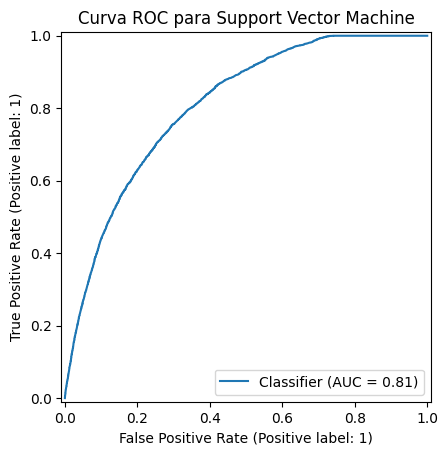

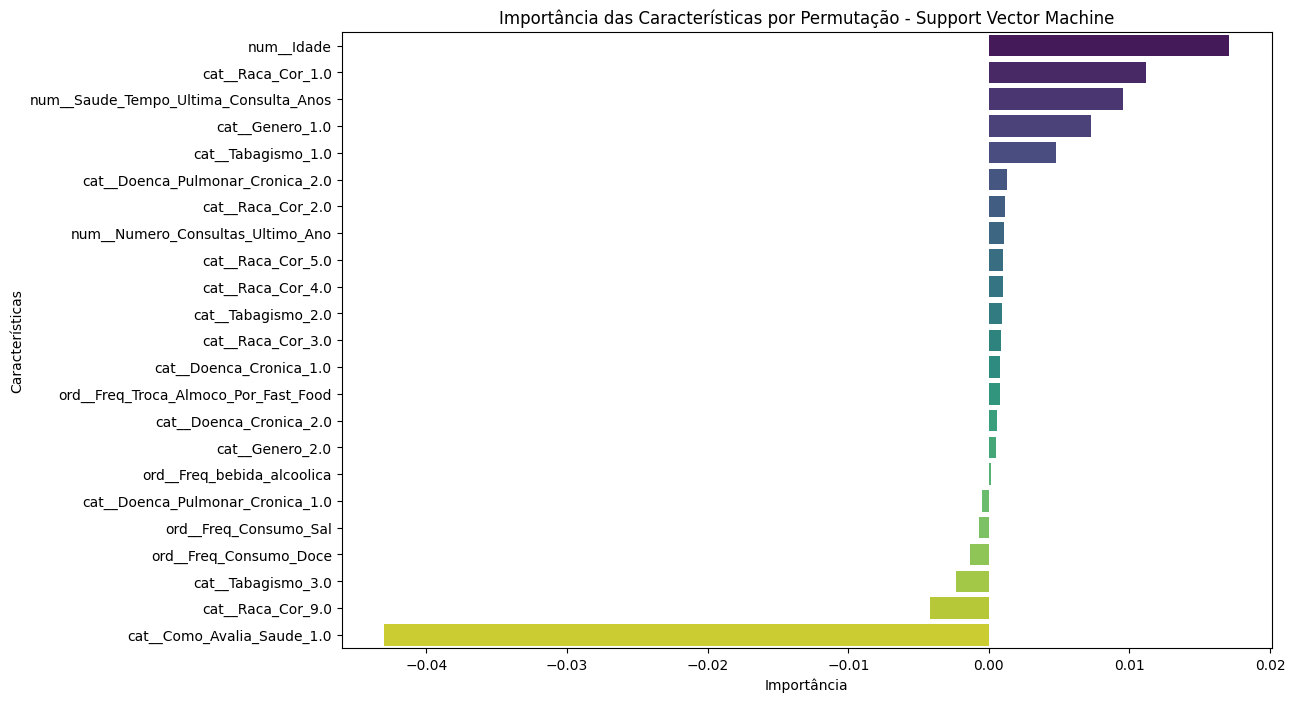


Treinando o modelo: XGBoost
Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\anton\Downloads\pns\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:05:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Melhores hiperparâmetros para XGBoost: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.7}


<Figure size 800x600 with 0 Axes>

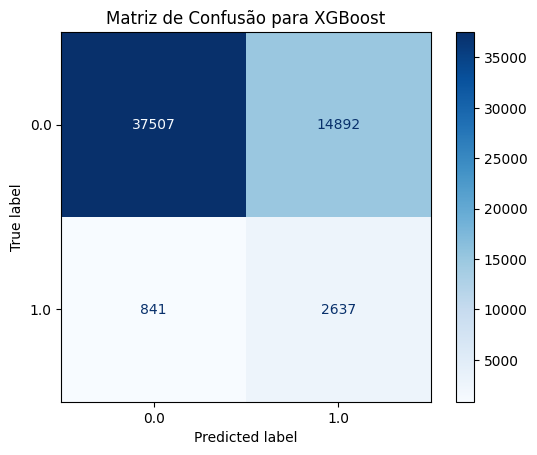

Relatório de Classificação para XGBoost:

              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     52399
         1.0       0.15      0.76      0.25      3478

    accuracy                           0.72     55877
   macro avg       0.56      0.74      0.54     55877
weighted avg       0.93      0.72      0.79     55877

Acurácia: 0.7184
ROC-AUC: 0.8218


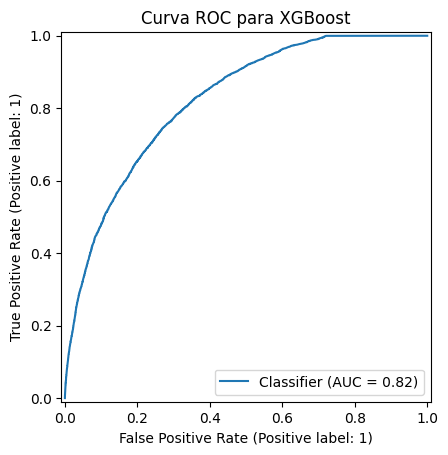

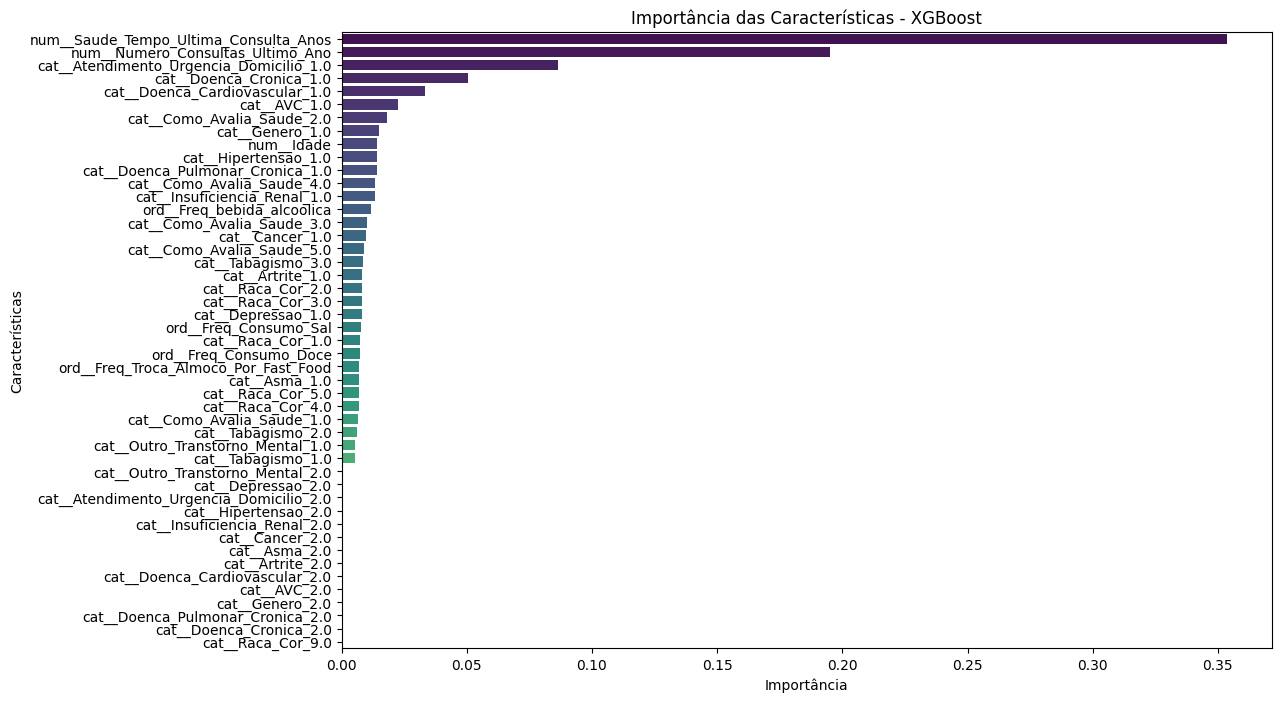


Treinando o modelo: LightGBM
Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\anton\Downloads\pns\env\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\anton\Downloads\pns\env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\anton\Downloads\pns\env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\anton\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\anton\AppData\Loc

[LightGBM] [Info] Number of positive: 13914, number of negative: 13914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 27828, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores hiperparâmetros para LightGBM: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 10, 'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'classifier__subsample': 0.7}


<Figure size 800x600 with 0 Axes>

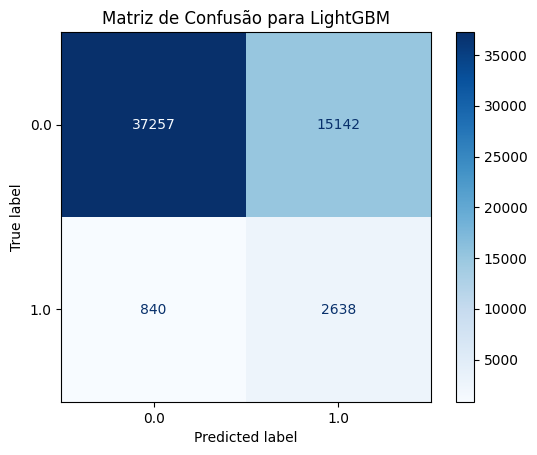

Relatório de Classificação para LightGBM:

              precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     52399
         1.0       0.15      0.76      0.25      3478

    accuracy                           0.71     55877
   macro avg       0.56      0.73      0.54     55877
weighted avg       0.93      0.71      0.79     55877

Acurácia: 0.7140
ROC-AUC: 0.8210


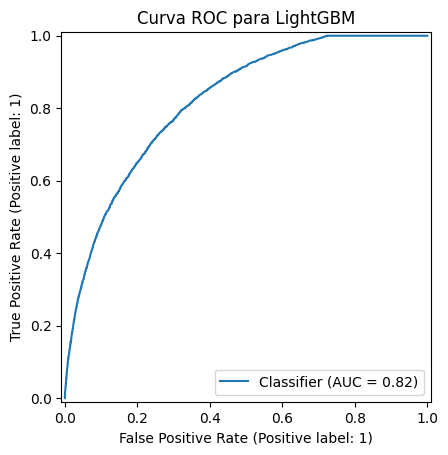

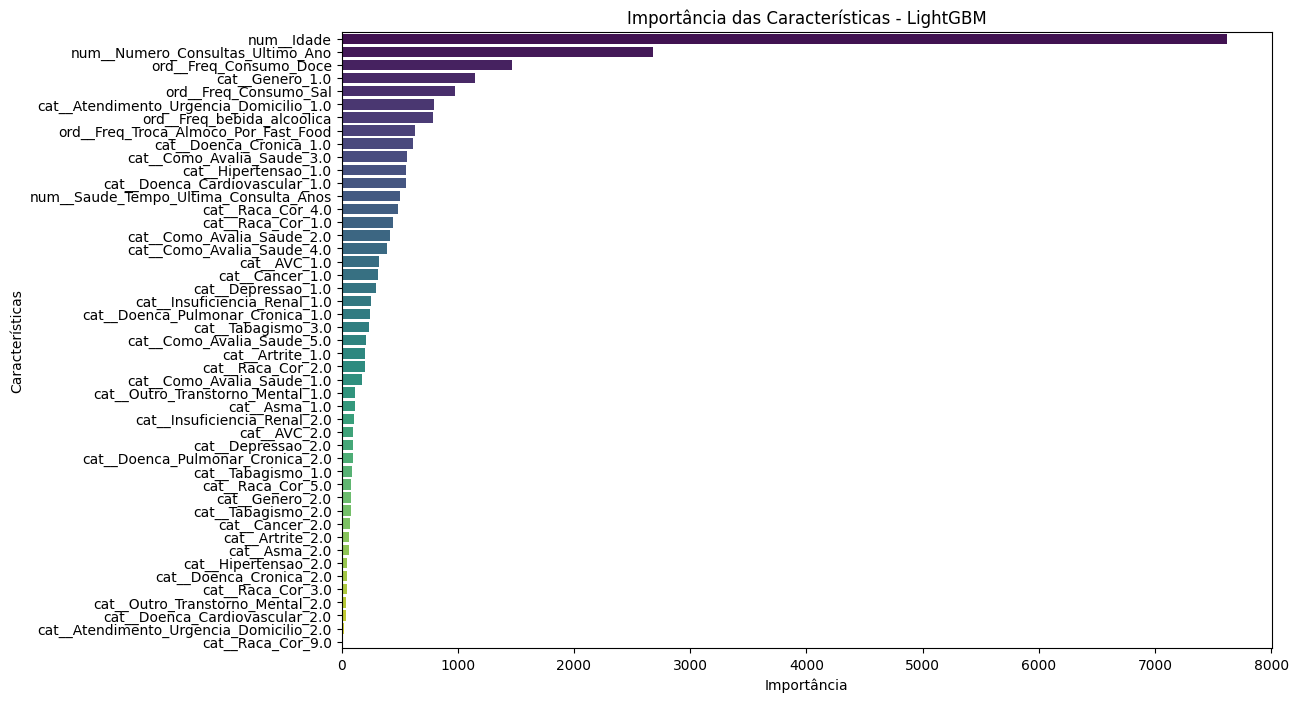

In [21]:
# Atualizando labels
# 1 se a pessoa foi internada nos últimos 12 meses, 0 caso contrário
y_train_balanced = y_train_balanced.replace({1.0: 1, 2.0: 0})
y_test = y_test.replace({1.0: 1, 2.0: 0})

# Definir os classificadores e hiperparâmetros para o GridSearchCV
classifiers = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [None, 5, 10, 20, 30],
            'classifier__criterion': ['gini', 'entropy', 'log_loss'],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__max_depth': [None, 10, 20, 30],
            'classifier__max_features': ['auto', 'sqrt', 'log2'],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__bootstrap': [True, False],
        }
    },
    'MLP Neural Network': {
        'model': MLPClassifier(random_state=42, max_iter=500),
        'params': {
            'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 100, 50)],
            'classifier__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'classifier__solver': ['lbfgs', 'sgd', 'adam'],
            'classifier__alpha': [0.0001, 0.001, 0.01],
            'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.001, 0.01, 0.1],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.7, 1.0],
            'classifier__max_features': ['auto', 'sqrt', 'log2'],
        }
    },
    'Support Vector Machine': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'classifier__C': [0.1, 1, 10, 100],
            'classifier__kernel': ['linear', 'rbf', 'poly'],
            'classifier__gamma': ['scale', 'auto'],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.001, 0.01, 0.1],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.7, 1.0],
            'classifier__colsample_bytree': [0.7, 1.0],
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [100, 200, 500],
            'classifier__learning_rate': [0.001, 0.01, 0.1],
            'classifier__max_depth': [-1, 5, 10],
            'classifier__num_leaves': [31, 50, 100],
            'classifier__subsample': [0.7, 1.0],
        }
    }
}

# Percorrer cada classificador e aplicar o GridSearchCV
for name, classifier_info in classifiers.items():
    print(f"\nTreinando o modelo: {name}")
    
    # Criar o pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier_info['model'])
    ])
    
    # Definir hiperparâmetros para o GridSearch
    param_grid = classifier_info['params']
    
    # Inicializar o GridSearchCV
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
    )
    
    # Treinar o modelo com GridSearch
    grid_search.fit(X_train_balanced, y_train_balanced)
    
    # Exibir os melhores hiperparâmetros
    print(f"Melhores hiperparâmetros para {name}: {grid_search.best_params_}")
    
    # Fazer previsões no conjunto de teste
    y_pred = grid_search.predict(X_test)
    
    # Matriz de Confusão aprimorada
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, cmap='Blues', normalize=None, values_format='d'
    )
    disp.ax_.set_title(f'Matriz de Confusão para {name}')
    plt.show()
    
    print(f"Relatório de Classificação para {name}:\n")
    print(classification_report(y_test, y_pred))
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Acurácia: {accuracy:.4f}")
    
    # ROC-AUC para classificação binária
    if len(set(y_test)) == 2:
        y_score = grid_search.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score)
        print(f"ROC-AUC: {auc:.4f}")
        
        # Plotar a Curva ROC
        RocCurveDisplay.from_predictions(y_test, y_score)
        plt.title(f'Curva ROC para {name}')
        plt.show()
    
    # Extração de Importância de Características
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
        # Importâncias das características diretamente do modelo
        importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
        feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
        
        # Ordenar as importâncias
        indices = np.argsort(importances)[::-1]
        sorted_importances = importances[indices]
        sorted_features = np.array(feature_names)[indices]
        
        # Plotar as importâncias das características
        plt.figure(figsize=(12, 8))
        sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
        plt.title(f'Importância das Características - {name}')
        plt.xlabel('Importância')
        plt.ylabel('Características')
        plt.show()
        
    elif name == 'MLP Neural Network' or name == 'Support Vector Machine':
        # Usar importância por permutação
        result = permutation_importance(
            grid_search.best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        importances = result.importances_mean
        feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
        
        # Ordenar as importâncias
        indices = np.argsort(importances)[::-1]
        sorted_importances = importances[indices]
        sorted_features = np.array(feature_names)[indices]
        
        # Plotar as importâncias das características
        plt.figure(figsize=(12, 8))
        sns.barplot(x=sorted_importances, y=sorted_features, palette='viridis')
        plt.title(f'Importância das Características por Permutação - {name}')
        plt.xlabel('Importância')
        plt.ylabel('Características')
        plt.show()
